In [1]:
import pandas as pd
import ipywidgets as widgets #8.1.0
from IPython.display import display
import plotly.express as px
import io
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [2]:
file_upload = widgets.FileUpload(
    accept='.csv', 
    multiple=False  
)
display(file_upload)

FileUpload(value=(), accept='.csv', description='Upload')

### Overall stats

In [4]:
if file_upload.value:
    uploaded_file = file_upload.value[0]
    print("Uploaded file: ",uploaded_file['name'])
    df = pd.DataFrame(pd.read_csv(io.BytesIO(uploaded_file['content'].tobytes())))
    data = df.copy()
    data["date"] = pd.to_datetime(data["created_at"]).dt.date
    data["time"] = pd.to_datetime(data["created_at"]).dt.time

date_range = [str(i) for i in data["date"].unique()]
total_bets_per_day = (data[data["round_type"] == "BET"].groupby("date")["real_amount"].sum())
total_wins_per_day = (data[data["round_type"] == "WIN"].groupby("date")["real_amount"].sum())
rtp = (total_wins_per_day.sum()/total_bets_per_day.sum())*100
perDay_rtp = (total_wins_per_day/total_bets_per_day)*100
cumulative_rtp = perDay_rtp.cumsum() 
ggr = total_bets_per_day.sum() - total_wins_per_day.sum()
perDay_ggr = total_bets_per_day - total_wins_per_day
cumulative_ggr = perDay_ggr.cumsum()
c_ggr = (total_bets_per_day - total_wins_per_day).cumsum()
unique_games = ['all'] + data["game_id"].unique().tolist()

print("Total Days Played: ", data["date"].nunique())
print("Date Range: ", date_range)
print("Total Sessions Played: ", data["session_id"].nunique())
print("Total rounds Played: ", data["macro_round_id"].nunique())
print("Total RTP: ", rtp)
print("Total GGR: ", ggr)

Uploaded file:  combined_data.csv
Total Days Played:  12
Date Range:  ['2023-08-17', '2023-08-20', '2023-08-21', '2023-08-19', '2023-08-18', '2023-08-13', '2023-08-12', '2023-08-11', '2023-08-10', '2023-08-08', '2023-08-16', '2023-08-15']
Total Sessions Played:  95
Total rounds Played:  542
Total RTP:  17.432667775646895
Total GGR:  6.980253


### Biggest WIN data

In [5]:
data.iloc[data[data["round_type"] == "WIN"]["real_amount"].idxmax()]

player_uuid                  PLAYER-d1891509-498e-498a-82a1-0e723e342e69
session_id                          38dc3751-7545-4632-8069-2a68b7848a03
round_id                        1ab_de32dcbd-6e84-41d0-83fd-7f2e75308ccc
macro_round_id                                   1ab-cri1d0r0-2693937944
transaction_id                  1ab_ce32dcbd-6e84-41d0-83fd-7f2e75308ccc
aggregator_id                                                  softswiss
provider_id                                                        ezugi
game_id                                         EZDealerRoletaBrazileira
internal_game_id       EZDealerRoletaBrazileira:DESKTOP_AND_MOBILE:ez...
round_type                                                           WIN
currency                                                             BCH
real_amount                                                          0.6
bonus_amount                                                         0.0
total_stake_amount                                 

### Biggest BET data

In [6]:
data.iloc[data[data["round_type"] == "BET"]["total_stake_amount"].idxmax()]

player_uuid                 PLAYER-d1891509-498e-498a-82a1-0e723e342e69
session_id                         578c3025-c0e7-44d0-b656-e12341b37322
round_id                       1ab_da823b72-2e4a-41ab-9e27-8e45bb7cb9df
macro_round_id                                  1ab-cri1d3ge-2693977353
transaction_id                 1ab_da823b72-2e4a-41ab-9e27-8e45bb7cb9df
aggregator_id                                                 softswiss
provider_id                                                       ezugi
game_id                                                   RoletaDaSorte
internal_game_id       RoletaDaSorte:DESKTOP_AND_MOBILE:ezugi:softswiss
round_type                                                          BET
currency                                                            BCH
real_amount                                                      0.6399
bonus_amount                                                     0.0601
total_stake_amount                                              

### Pie chart for Total Rounds vs Rounds won

In [8]:
dropdown_games = widgets.Dropdown(
    options=unique_games,
    description='Select Game:',
    disabled=False,
    value='all'
)

def filter_dataframe(selected_id):
    if selected_id == 'all':
        filtered_df = data.copy()
    else:
        filtered_df = data[data["game_id"] == selected_id].copy()
    return filtered_df

def on_dropdown_change(selected_id):
    filtered_df = filter_dataframe(selected_id)
    total_rounds = filtered_df["macro_round_id"].nunique()
    total_rounds_won = filtered_df[(filtered_df["round_type"]=="WIN") & (filtered_df["real_amount"]>0)].shape[0]
    fig = px.pie(
    names=["Total Rounds", "Total Rounds won"],
    values=[total_rounds, total_rounds_won],
    title='Total vs Total Won'
    )
    fig.show()

widgets.interactive(on_dropdown_change, selected_id=dropdown_games)

interactive(children=(Dropdown(description='Select Game:', options=('all', 'SavageBuffaloSpirit', 'DiamondRoul…

### Bet Graph 

In [9]:
def on_dropdown_change(selected_id):
    filtered_df = filter_dataframe(selected_id)
    df = pd.DataFrame(
    {"x":(filtered_df[filtered_df["round_type"] == "BET"].groupby("date")["real_amount"].sum()),
     "y":(filtered_df[filtered_df["round_type"] == "WIN"].groupby("date")["real_amount"].sum()),
     "labels":[str(i) for i in filtered_df["date"].unique()]}
    )
    fig = px.bar(df, x='labels', y=['x', 'y'], color_discrete_sequence=['blue', 'orange'],
             labels={'labels': 'Date', 'value': 'Amount'},
             title='Bet Graph',
             template='plotly')
    fig.update_layout(barmode='group')
    fig.show()
    
widgets.interactive(on_dropdown_change, selected_id=dropdown_games)

interactive(children=(Dropdown(description='Select Game:', index=5, options=('all', 'SavageBuffaloSpirit', 'Di…

### RTP and GGR 

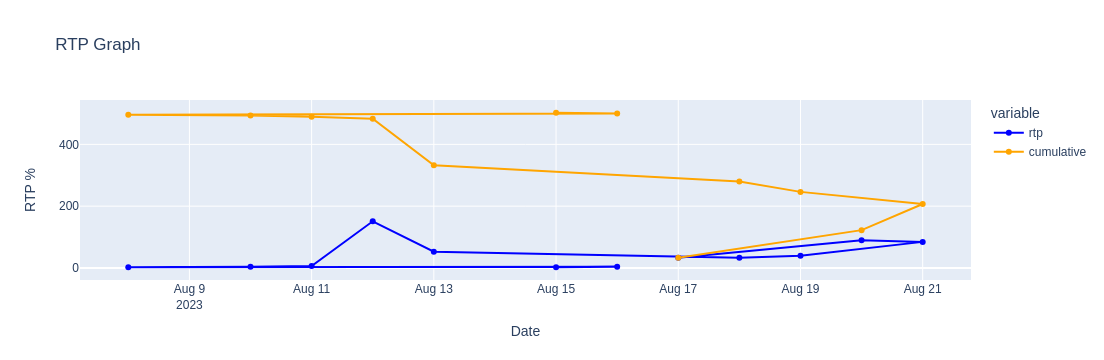

In [10]:
df = pd.DataFrame({"rtp":perDay_rtp,"cumulative":cumulative_rtp,"labels":date_range})
fig = px.line(df, x="labels", y=["rtp", "cumulative"],
              markers=True, color_discrete_sequence=['blue', 'orange'],
              labels={"labels":"Date", "value": "RTP %"},
              title="RTP Graph")

fig.show()

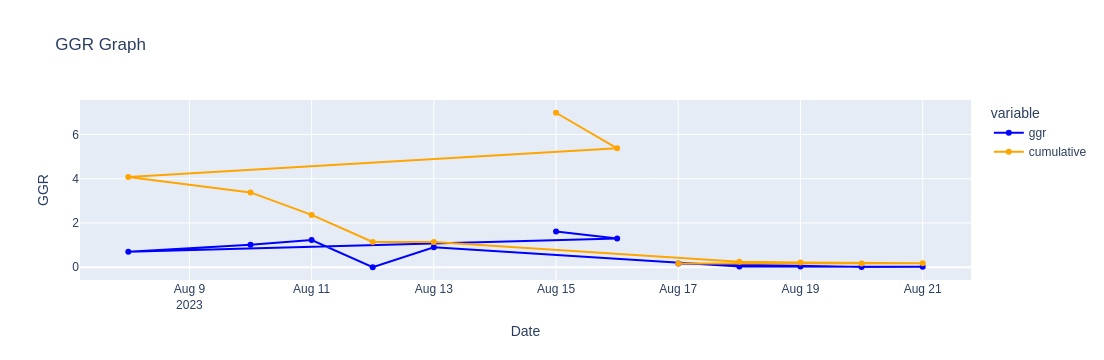

In [11]:
df = pd.DataFrame({"ggr":perDay_ggr,"cumulative":cumulative_ggr,"labels":date_range})
fig = px.line(df, x="labels", y=["ggr", "cumulative"],
              markers=True, color_discrete_sequence=['blue', 'orange'],
              labels={"labels":"Date", "value": "GGR"},
              title="GGR Graph")

fig.show()

In [12]:
stats_df = data.groupby(['game_id','round_type'])['real_amount'].sum().to_frame()
stats_df = stats_df.reset_index().pivot(index="game_id", 
                                          columns="round_type",
                                          values = "real_amount")
stats_df.columns = [col.lower() for col in stats_df.columns]
stats_df = stats_df.fillna(0)
game_rounds = data.groupby('game_id')['macro_round_id'].nunique()

In [13]:
stats_df['rtp'] = (stats_df['win']/stats_df['bet']) * 100
stats_df['ggr'] = stats_df['bet'] - stats_df['win']
stats_df['rounds'] = game_rounds.values
stats_df[['rtp', 'ggr', 'rounds']]

,rtp,ggr,rounds
game_id,,,
AutomaticRoulette,2.363823,0.950000,8
AutomaticRoulette1,7.692308,0.048000,2
BookOfKemet,46.341463,0.022000,41
BurningSunEaster,0.000000,0.008400,21
CasinoMarinaRoulette1,0.000000,0.004000,1
CasinoMarinaRoulette2,0.000000,0.054000,2
DiamondRoulette,15.314501,0.652512,34
EZDealerRoletaBrazileira,148.883375,-0.197000,2
EZDealerRoulette,120.000000,-0.001000,2
